In [1]:
import tifffile as tf
from scipy import ndimage
import numpy as np

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
fs = 15
resol = 0.0759

wsrc = '../hpcc/clean/'
tsrc = '../hpcc/watershed/'
rsrc = '../hpcc/rotated/'
dst = '../hpcc/traditional/'

struc1 = ndimage.generate_binary_structure(3, 1)
struc2 = ndimage.generate_binary_structure(3, 2)
struc3 = ndimage.generate_binary_structure(3, 3)

ssrange = [100,150,200,250,300]

Sx = [ np.s_[k,:,:] for k in ssrange ]
Sy = [ np.s_[:,k,:] for k in ssrange ]
Sz = [ np.s_[:,:,k] for k in ssrange ]

fs = 15

In [3]:
idname = '2012SB'

rownum = 16
treenum = 58
nutnum = 1

bname = idname + '_R{}_T{}'.format(rownum, treenum)
print(bname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

2012SB_R16_T58
../hpcc/traditional/2012SB_R16_T58/


In [4]:
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(wsrc + bname + '/' + fname + '.tif')
mxval = 2**(8*img.itemsize)-1
tissuefiles = sorted(glob.glob(tsrc + bname + '/' + fname + '_*.tif'))

if True:
    air  = tf.imread(tissuefiles[0])
    meat = tf.imread(tissuefiles[1])
    shell= tf.imread(tissuefiles[2])
    vein = tf.imread(tissuefiles[3])

mxval = 2**(8*img.itemsize)

2012SB_R16_T58_001


In [109]:
dshell = shell.copy()
dshell = ndimage.binary_dilation(dshell, struc1, 10, border_value=0)
dshell = ndimage.binary_erosion(dshell, struc1, 10, border_value=1)

In [110]:
cavity = np.zeros_like(img, dtype=img.dtype)
cavity[air > 0] = 1
cavity = wnut.get_largest_element(cavity)
cavity[meat > 0] = 1
cavity[vein > 0] = 1

276 components	 1 preserved
[40096582   389519    16163     5657     2750     2535     2300     2275
     1305     1273     1270     1088      932      901      872      765
      572      568      563      560]


In [111]:
N = 5
cavity[img == 0] = 2
cavity[dshell > 0] = 0
maxf = ndimage.maximum_filter(cavity, size=3)
foo = maxf != cavity
foo[cavity == 0] = False

foo = wnut.get_largest_element(foo)

bar = ndimage.binary_dilation(foo, struc3, 4*N, border_value=0)

dcav = cavity.copy()
dcav[img == 0] = 0
dcav[bar == True] = 1

133 components	 1 preserved
[10489    55    36    31    18    14     6     6     4     4     4     4
     4     4     3     3     3     3     2     2]


In [103]:
fill = wnut.fill_component(dcav)

Closed X
Closed Y
Closed Z


In [104]:
dfill = ndimage.binary_dilation(fill, struc1, N, border_value=0)
efill = ndimage.binary_erosion(dfill, struc1, 3*N, border_value=1)

cshell = shell * efill

In [105]:
#cshell = shell * efill
bshell, labels, where = wnut.get_largest_element(cshell, thr=5e-3, outlabels=True)
#bshell = shell*bar

8 components	 3 preserved
[139881  17197   4315    107     60      1      1      1]


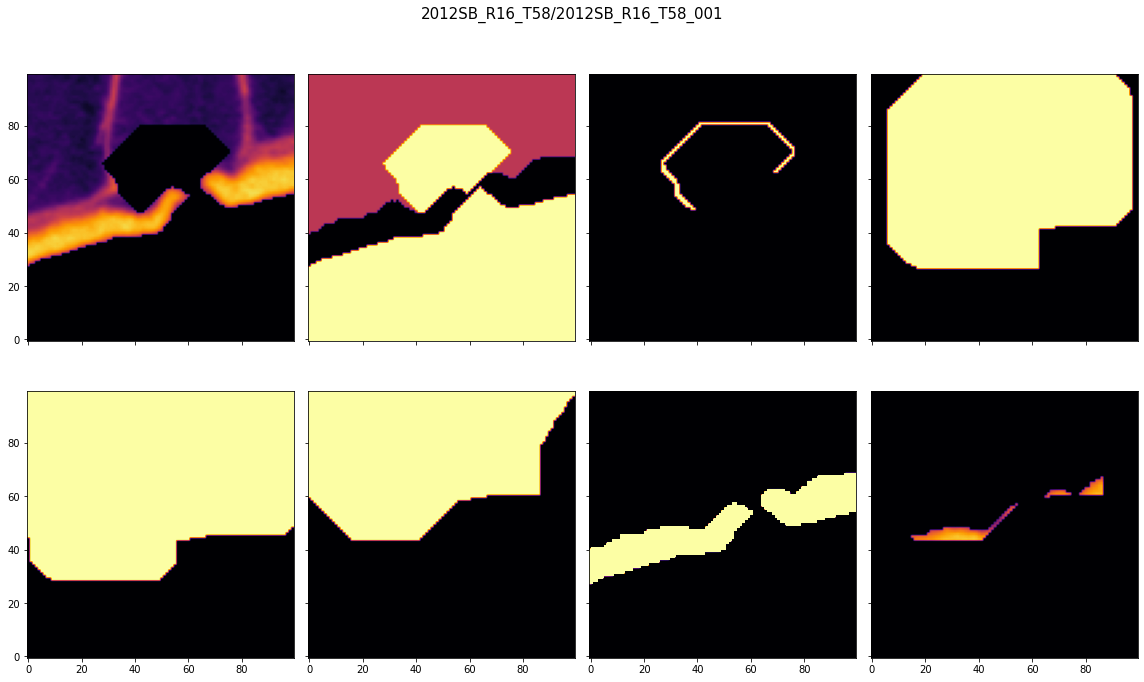

In [114]:
k = 160
ss = np.s_[:,:,k]
#ss = np.s_[k,:,:]
ss = np.s_[:100, 250:350, k]
#ss = np.s_[480:, 220:270, k]

fig, ax = plt.subplots(2,4,figsize=(16,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()
i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(cavity[ss], cmap='inferno', origin='lower')
i = 2
ax[i].imshow(foo[ss], cmap='inferno', origin='lower')
i = 3
ax[i].imshow(bar[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 4
ax[i].imshow(dfill[ss], cmap='inferno', origin='lower')
i = 5
ax[i].imshow(efill[ss], cmap='inferno', origin='lower')
i = 6
ax[i].imshow(shell[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 7
ax[i].imshow(bshell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()

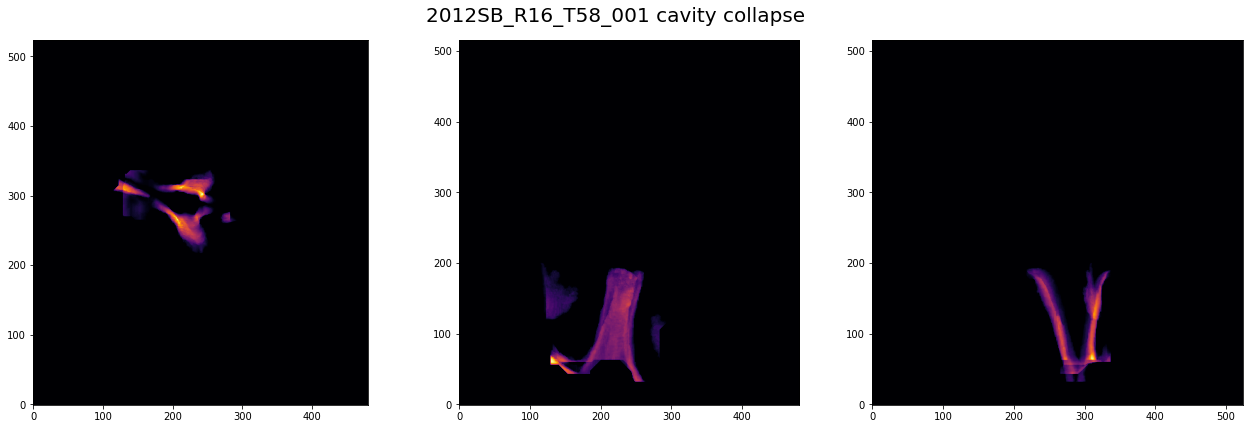

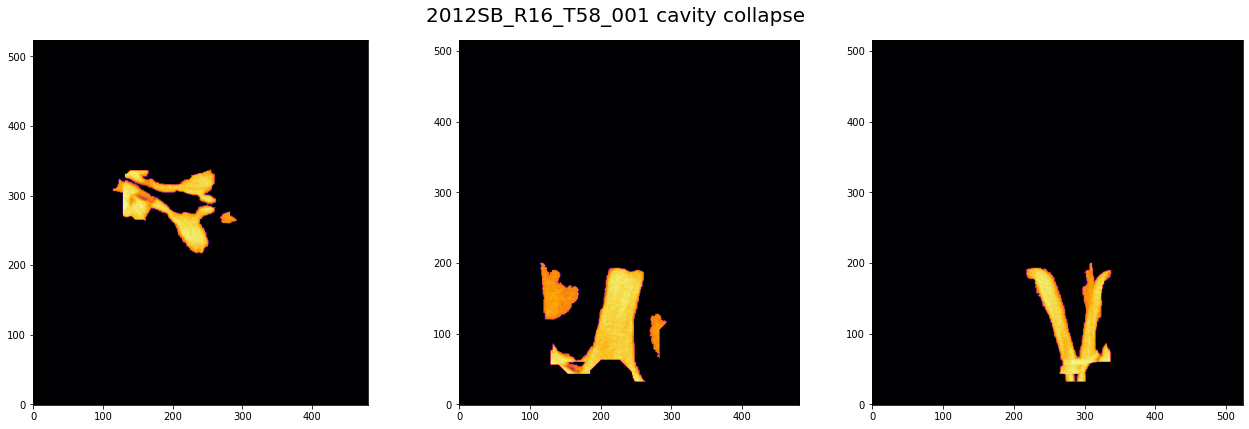

In [107]:
snaps = wnut.collapse_dimensions(bshell)
wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdst, writefig=False, display=True)

snaps = wnut.collapse_dimensions_max(bshell)
wnut.plot_collapse_dimensions(snaps, fname, 'cavity', dst=wdst, writefig=False, display=True)